# https://medium.com/@thechrisyoon/deriving-policy-gradients-and-implementing-reinforce-f887949bd63

In [1]:
import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt

# Constants
GAMMA = 0.9

# policy network

class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(PolicyNetwork, self).__init__()

        self.num_actions = num_actions
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.softmax(self.linear2(x), dim=1)
        return x 
    
    def get_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.forward(Variable(state))
        highest_prob_action = np.random.choice(self.num_actions, p=np.squeeze(probs.detach().numpy()))
        log_prob = torch.log(probs.squeeze(0)[highest_prob_action])
        return highest_prob_action, log_prob


In [2]:
def update_policy(policy_network, rewards, log_probs):
    discounted_rewards = []

    for t in range(len(rewards)):
        Gt = 0 
        pw = 0
        for r in rewards[t:]:
            Gt = Gt + GAMMA**pw * r
            pw = pw + 1
        discounted_rewards.append(Gt)
        
    discounted_rewards = torch.tensor(discounted_rewards)
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9) # normalize discounted rewards

    policy_gradient = []
    for log_prob, Gt in zip(log_probs, discounted_rewards):
        policy_gradient.append(-log_prob * Gt)
    
    policy_network.optimizer.zero_grad()
    policy_gradient = torch.stack(policy_gradient).sum()
    policy_gradient.backward()
    policy_network.optimizer.step()

In [3]:
def main():
    env = gym.make('CartPole-v0').env
    policy_net = PolicyNetwork(env.observation_space.shape[0], env.action_space.n, 128)
    
    max_episode_num = 500
    max_steps = 10000
    numsteps = []
    avg_numsteps = []
    all_rewards = []

    for episode in range(max_episode_num):
        state = env.reset()
        log_probs = []
        rewards = []

        for steps in range(max_steps):
            env.render()
            action, log_prob = policy_net.get_action(state)
            new_state, reward, done, _ = env.step(action)
            log_probs.append(log_prob)
            rewards.append(reward)

            if done:
                update_policy(policy_net, rewards, log_probs)
                numsteps.append(steps)
                avg_numsteps.append(np.mean(numsteps[-10:]))
                all_rewards.append(np.sum(rewards))
                if episode % 1 == 0:
                    sys.stdout.write("episode: {}, total reward: {}, average_reward: {}, length: {}\n".format(episode, np.round(np.sum(rewards), decimals = 3),  np.round(np.mean(all_rewards[-10:]), decimals = 3), steps))
                break
            
            state = new_state
        
    plt.plot(numsteps)
    plt.plot(avg_numsteps)
    plt.xlabel('Episode')
    plt.show()

episode: 0, total reward: 14.0, average_reward: 14.0, length: 13
episode: 1, total reward: 22.0, average_reward: 18.0, length: 21
episode: 2, total reward: 16.0, average_reward: 17.333, length: 15
episode: 3, total reward: 10.0, average_reward: 15.5, length: 9
episode: 4, total reward: 10.0, average_reward: 14.4, length: 9
episode: 5, total reward: 35.0, average_reward: 17.833, length: 34
episode: 6, total reward: 17.0, average_reward: 17.714, length: 16
episode: 7, total reward: 16.0, average_reward: 17.5, length: 15
episode: 8, total reward: 26.0, average_reward: 18.444, length: 25
episode: 9, total reward: 14.0, average_reward: 18.0, length: 13
episode: 10, total reward: 12.0, average_reward: 17.8, length: 11
episode: 11, total reward: 12.0, average_reward: 16.8, length: 11
episode: 12, total reward: 11.0, average_reward: 16.3, length: 10
episode: 13, total reward: 16.0, average_reward: 16.9, length: 15
episode: 14, total reward: 39.0, average_reward: 19.8, length: 38
episode: 15, t

episode: 124, total reward: 26.0, average_reward: 24.5, length: 25
episode: 125, total reward: 13.0, average_reward: 23.5, length: 12
episode: 126, total reward: 16.0, average_reward: 23.6, length: 15
episode: 127, total reward: 35.0, average_reward: 25.6, length: 34
episode: 128, total reward: 20.0, average_reward: 25.3, length: 19
episode: 129, total reward: 11.0, average_reward: 24.5, length: 10
episode: 130, total reward: 9.0, average_reward: 23.3, length: 8
episode: 131, total reward: 35.0, average_reward: 24.9, length: 34
episode: 132, total reward: 25.0, average_reward: 25.8, length: 24
episode: 133, total reward: 20.0, average_reward: 21.0, length: 19
episode: 134, total reward: 19.0, average_reward: 20.3, length: 18
episode: 135, total reward: 64.0, average_reward: 25.4, length: 63
episode: 136, total reward: 54.0, average_reward: 29.2, length: 53
episode: 137, total reward: 67.0, average_reward: 32.4, length: 66
episode: 138, total reward: 16.0, average_reward: 32.0, length: 

episode: 247, total reward: 39.0, average_reward: 37.6, length: 38
episode: 248, total reward: 20.0, average_reward: 36.1, length: 19
episode: 249, total reward: 26.0, average_reward: 37.0, length: 25
episode: 250, total reward: 46.0, average_reward: 36.9, length: 45
episode: 251, total reward: 40.0, average_reward: 36.6, length: 39
episode: 252, total reward: 18.0, average_reward: 36.4, length: 17
episode: 253, total reward: 50.0, average_reward: 38.8, length: 49
episode: 254, total reward: 36.0, average_reward: 38.2, length: 35
episode: 255, total reward: 17.0, average_reward: 34.4, length: 16
episode: 256, total reward: 17.0, average_reward: 30.9, length: 16
episode: 257, total reward: 75.0, average_reward: 34.5, length: 74
episode: 258, total reward: 15.0, average_reward: 34.0, length: 14
episode: 259, total reward: 73.0, average_reward: 38.7, length: 72
episode: 260, total reward: 29.0, average_reward: 37.0, length: 28
episode: 261, total reward: 15.0, average_reward: 34.5, length

episode: 370, total reward: 21.0, average_reward: 36.8, length: 20
episode: 371, total reward: 46.0, average_reward: 37.8, length: 45
episode: 372, total reward: 21.0, average_reward: 38.0, length: 20
episode: 373, total reward: 22.0, average_reward: 37.4, length: 21
episode: 374, total reward: 76.0, average_reward: 38.3, length: 75
episode: 375, total reward: 29.0, average_reward: 37.4, length: 28
episode: 376, total reward: 38.0, average_reward: 36.6, length: 37
episode: 377, total reward: 74.0, average_reward: 41.0, length: 73
episode: 378, total reward: 121.0, average_reward: 49.2, length: 120
episode: 379, total reward: 18.0, average_reward: 46.6, length: 17
episode: 380, total reward: 50.0, average_reward: 49.5, length: 49
episode: 381, total reward: 58.0, average_reward: 50.7, length: 57
episode: 382, total reward: 18.0, average_reward: 50.4, length: 17
episode: 383, total reward: 20.0, average_reward: 50.2, length: 19
episode: 384, total reward: 25.0, average_reward: 45.1, leng

episode: 493, total reward: 86.0, average_reward: 63.5, length: 85
episode: 494, total reward: 89.0, average_reward: 67.9, length: 88
episode: 495, total reward: 55.0, average_reward: 60.0, length: 54
episode: 496, total reward: 19.0, average_reward: 52.4, length: 18
episode: 497, total reward: 17.0, average_reward: 51.7, length: 16
episode: 498, total reward: 68.0, average_reward: 53.1, length: 67
episode: 499, total reward: 137.0, average_reward: 65.0, length: 136


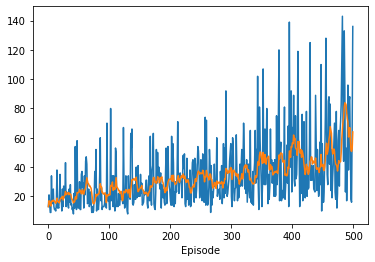

In [4]:
main()